# Quantum Simulated Annealing optimization using Monte Carlo methods

In [1]:
# Imports
%matplotlib inline
import numpy as np
import math
from random import randint
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['interactive'] == True
from scipy.optimize import minimize
from qiskit_aer.aerprovider import AerSimulator
from qiskit_aer import Aer, aerprovider
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import HGate, ZGate
from qiskit.circuit import ClassicalRegister, QuantumRegister
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import *

## Helper functions

In [2]:
'''
Reversely find a parameter.

Input y is desired prepared quantum state. (L2 Normalized |y|^2 = 1)
Input optimization_method is function used to optimize the parameters.
Find parameters of variational quantum circuit "RealAmplitude" that can prepare y.
'''
def find_parameter(y, optimization_method: callable):
    n = int(math.log2(len(y))) 
    ansatz = RealAmplitudes(n, reps=1) 
    parameters = np.ones(ansatz.num_parameters)  
    simulator = AerSimulator(method='statevector') 
    meas = ClassicalRegister(1, "meas") 
    qreg = QuantumRegister(2 * n + 1) 
    c = QuantumCircuit(qreg, meas) 

    # Prepare the circuit for the swap test
    a = [1]
    b = [n + 1]
    for i in range(2, n + 1):
        a.append(i)
        b.append(n + i)

    final = c.compose(ansatz, a) 
    final.initialize(y, b) 
    final.save_statevector(label="ans") 
    final.h(0) 

    # Perform the swap test
    for i in range(1, n + 1):
        final.cswap(0, i, n + i) 
    final.h(0) 
    final.measure([0], meas) 

    # Transpile and run the circuit
    circ = transpile(final, simulator) 
    circfinal = circ.assign_parameters(parameters) 
    results = simulator.run(circfinal).result() 
    init_counts = results.get_counts()
    print(f"Counts before optimization: {init_counts}") 
    
    # Visualize results of the original implementation
    visualize_results(init_counts, "Before Optimization")

    # Optimization
    Energy = E(parameters, circ, simulator) 
    anneal = optimization_method(100, parameters, circ, simulator) 
    print(f"Energy: {Energy}") 

    # Update circuit with optimized parameters and run again
    circfinal = circ.assign_parameters(anneal)
    results = simulator.run(circfinal).result()
    optimized_counts = results.get_counts() 
    

    # Calculate and print results
    b = optimized_counts.get('1', 0) 
    s = (1 - (2 / 1024) * b) 
    circfinal.draw(output="mpl")
    matplotlib.pyplot.show() 
    print(f"After optimization: {str(results.get_counts())}") 
    print(f"Success value: {s}")

    # Visualize results of the Monte Carlo optimization
    visualize_results(optimized_counts, "After Optimization")

    # Calculate and print partial traces
    temp = partial_trace(results.data(0)['ans'], [0, 3, 4])
    partial = np.diagonal(temp)
    temp = partial_trace(results.data(0)['ans'], [0, 1, 2])
    partial2 = np.diagonal(temp)
    norm = np.linalg.norm(partial - partial2) 
    print("Norm of the difference between partial traces:", norm)

    return parameters 

# Function to calculate cost based on parameters
def cost_func(params, ansatz, simulator):
    circfinal = ansatz.assign_parameters(params) 
    results = simulator.run(circfinal, shots=1024).result() 
    counts = results.get_counts() 
    b = counts.get('1', 0) 
    s = -1 * (1 - ((2 / 1024) * b)) 
    return s 

# Function to calculate energy based on parameters
def E(params, ansatz, simulator):
    circfinal = ansatz.assign_parameters(params) 
    results = simulator.run(circfinal, shots=20).result() 
    temp = partial_trace(results.data(0)['ans'], [0, 3, 4])
    partial = np.diagonal(temp) 
    temp = partial_trace(results.data(0)['ans'], [0, 1, 2])
    partial2 = np.diagonal(temp) 
    norm = np.linalg.norm(partial - partial2) 
    return norm 

# Function to visualize the results of the quantum circuit
def visualize_results(counts, title):
    plt.bar(counts.keys(), counts.values())
    plt.title(title)
    plt.xlabel('Measurement Outcome')
    plt.ylabel('Counts')
    plt.show()


## Monte Carlo Optimization Functions

In [4]:
# Simulated Annealing optimization
def simulated_annealing(runs, params, ansatz, simulator):
    B = E(params, ansatz, simulator) 
    prev_E = B

    # Temperature function for simulated annealing
    def T(t):
        c = 0.02
        a = 0.01
        temperature = c / (a + math.log(t)) 
        return temperature

    # Main loop for simulated annealing
    for t in range(1, runs):
        delta = np.random.normal(0, .1, 4) 
        params_new = params + delta 
        E_new = E(params_new, ansatz, simulator) 
        delta_E = E_new - prev_E 

        if delta_E <= 0:
            params = params_new
            prev_E = E_new
        else:
            h = math.pow(math.e, -1 * delta_E / T(t)) 
            U = np.random.normal(.5, .5, 1) 
            if U < h:
                params = params_new
                prev_E = E_new

    return params 

# Particle Swarm optimization
def particle_swarm(runs, params, ansatz, simulator):
    # To implement
    return params

# Differential Evolution optimization
def diff_evolution(runs, params, ansatz, simulator):
    # To implement
    return params

# Stochastic Hill Climbing optimization
def stochastic_hill_climbing(runs, params, ansatz, simulator):
    # To implement
    return params

# Compare the results

[0.61160966 0.56507415 0.04653552 0.55177828]
Counts before optimization: {'1': 139, '0': 885}


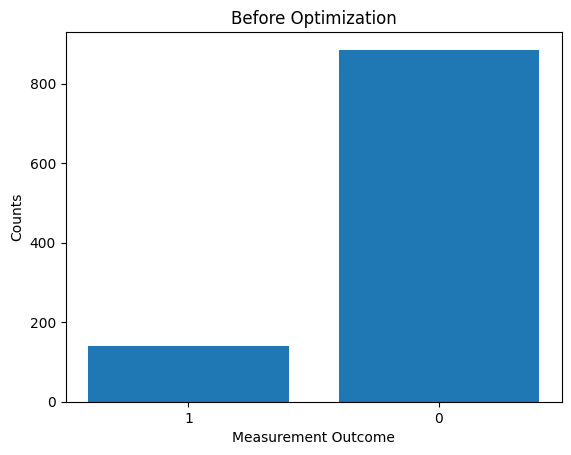

Energy: 0.47889090910972865


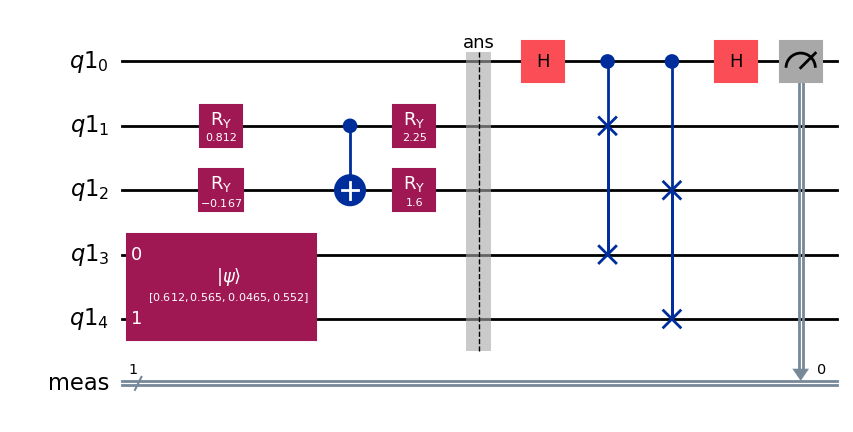

After optimization: {'1': 4, '0': 1020}
Success value: 0.9921875


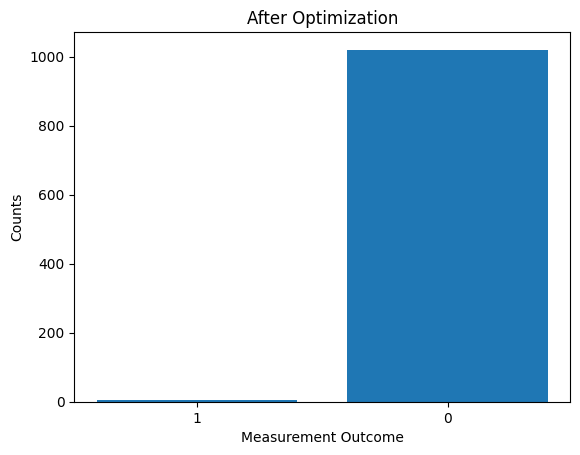

Norm of the difference between partial traces: 0.14768922255863412


In [5]:
# Main execution block
randvect = [randint(0, 100) for p in range(0, 4)] 
norm = np.linalg.norm(randvect) 
randvect = randvect / norm 
print(randvect) 
original_parameters = find_parameter(randvect, simulated_annealing)